In [151]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import numpy as np

In [152]:
#CLASSIFICATION TREE
df = pd.read_csv("Admission_Predict.csv") 
#columns names are with spaces and some upper cases letters
print(df.columns)
#replacing spaces with '_' and lowering every letter
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower() 
print(df.columns)

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')
Index(['serial_no.', 'gre_score', 'toefl_score', 'university_rating', 'sop',
       'lor', 'cgpa', 'research', 'chance_of_admit'],
      dtype='object')


In [153]:
#getting features, this takes every row and columns from gre_score to research 
X = df.loc[:,'gre_score':'research'] 
#this will output a Series, while  df[df['chance_of_admit >= 0.8']] would get a DataFrame
y = df.chance_of_admit >= 0.8 

#Building the model
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)

dt = DecisionTreeClassifier(max_depth = 2, ccp_alpha = 0.01, criterion = 'gini') 
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.925


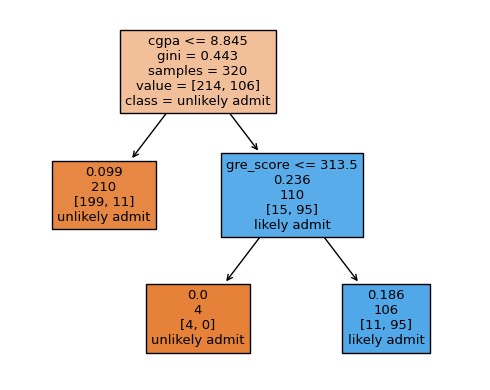

Text Representation of the Tree: 
 
 |--- cgpa <= 8.85
|   |--- class: False
|--- cgpa >  8.85
|   |--- gre_score <= 313.50
|   |   |--- class: False
|   |--- gre_score >  313.50
|   |   |--- class: True



In [154]:
#Plotting the Tree
plt.figure(figsize=(5,4))
plot_tree(dt, feature_names = x_train.columns, 
               max_depth = 3, class_names = ['unlikely admit', 'likely admit'],
               label = 'root', filled = True)
plt.tight_layout()
plt.show()

print('Text Representation of the Tree:' , '\n','\n', export_text(dt, feature_names = X.columns.tolist()))


In [155]:
#Double Chechking on the Branch Splitting:

#defining gini function for the impurity score
def gini(data):
    data = pd.Series(data)
    return (round(1 - sum(data.value_counts(normalize = True)**2), 3)) #this is equal to 1 - [sum_i (p_i^2)]

#Where all Ginis come from: (notice the power of Pd Series Indexing!)
gini_root = (gini(y_train))
gini_left = gini(y_train[x_train['cgpa'] <= 8.845])
gini_right = gini(y_train[x_train['cgpa'] > 8.845])
gini_right_left = gini(y_train[(x_train['cgpa'] > 8.845) & (x_train['gre_score'] <= 313.5)])
gini_right_right = gini(y_train[(x_train['cgpa'] > 8.845) & (x_train['gre_score'] > 313.5)])

#Defining an Info Gain Function
def info_gain(left, right, current_gini):
    #left and right branch as well as current impurity in the node you are measuring the info gain  
    weight = float(len(left)) /(len(left) + len(right))
    return current_gini - float(weight * gini(left)) - float((1 - weight) * gini(right))


     split_value  info_gain
10          8.84   0.296906
124         8.85   0.291719
139         8.88   0.290550
18          8.90   0.289828
98          8.83   0.288050


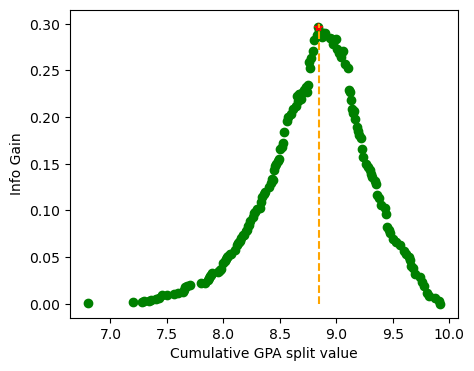

In [156]:
#Double Checking the Root (why is the cumulative GPA splitting value EXACTLY at 8.845?)
info_gain_list = []

for i in x_train.cgpa.unique(): #iterating through EVERY cgpa values
    left = y_train[x_train.cgpa <= i] #left branch for THAT value 
    right = y_train[x_train.cgpa > i] #right branch for THAT value
    info_gain_list.append([i, info_gain(left , right, gini_root)]) #current gini ≡ gini_root, because we are at root

#creating a DataFrame from the info_gain_list of shape (len,2) in descending order 
info_gain_table = pd.DataFrame(info_gain_list, columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
print(info_gain_table.head())

#Plotting Info_gain as a function of the splitting value
plt.figure(figsize=(5,4))
plt.plot( info_gain_table['split_value'], info_gain_table['info_gain'],'o',color = 'green')
plt.plot(info_gain_table['split_value'].iloc[0], info_gain_table['info_gain'].iloc[0],'r*') #plotting the best 
plt.xlabel('Cumulative GPA split value')
plt.ylabel('Info Gain')

#vertical line @8.845
line_x = [8.845, 8.845, 8.845, 8.845]
line_y = [0, 0.2 , 0.25, 0.3]
plt.plot(line_x,line_y , linestyle='dashed', color = 'orange')
plt.show()

0.5230242793515549


[Text(0.5, 0.8333333333333334, 'cgpa <= 8.845\nsquared_error = 0.021\nsamples = 320\nvalue = 0.727'),
 Text(0.25, 0.5, 'cgpa <= 8.035\nsquared_error = 0.012\nsamples = 210\nvalue = 0.651'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.009\nsamples = 60\nvalue = 0.533'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.006\nsamples = 150\nvalue = 0.698'),
 Text(0.75, 0.5, 'cgpa <= 9.195\nsquared_error = 0.005\nsamples = 110\nvalue = 0.872'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.003\nsamples = 55\nvalue = 0.816'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.001\nsamples = 55\nvalue = 0.928')]

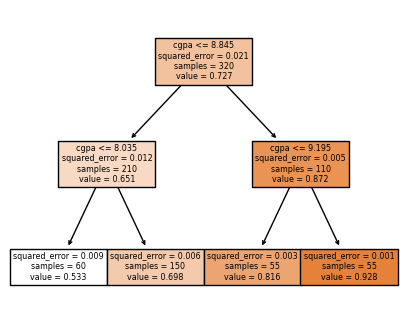

In [157]:
#REGRESSION TREE

#Unlike the classification problem, there are no longer classes to split the tree by. 
#Instead, at each level, the value is the average of all samples that fit the logical criteria. 
#In terms of evaluating the split, the default method is MSE (Mean Squared Errors)

#getting features and the target variable
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']

#usual procedure
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
dt = DecisionTreeRegressor(max_depth=3, ccp_alpha=0.001)

dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

#plotting the tree
plt.figure(figsize=(5,4))
plot_tree(dt, feature_names = x_train.columns,  
               max_depth=2, filled=True)


MSE at root: 0.021
     split_value  info_gain
10          8.84   0.011065
96          8.80   0.011037
98          8.83   0.011023
124         8.85   0.010985
125         8.73   0.010939
110         8.87   0.010932
139         8.88   0.010895
1           8.70   0.010894
17          8.76   0.010858
140         8.74   0.010850


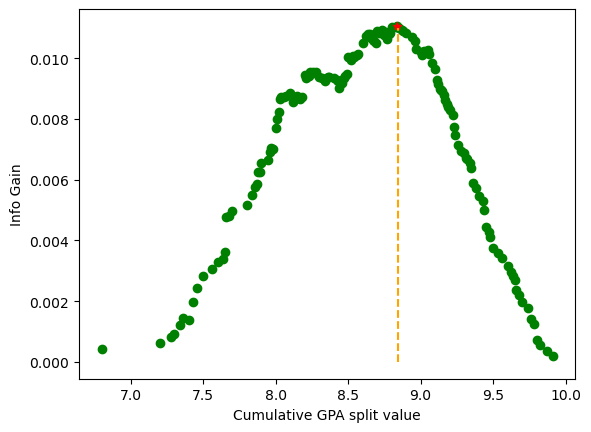

In [165]:
#Checking the tree

#defining a function that calculate the MSE of a data set
def mse(data):    
    return np.mean((data - data.mean())**2) 

#Information Gain (MSE) associated with creating a node/split data based on MSE
def mse_gain(left, right, current_mse):
    
    #weight for gini score of the left branch
    w = float((len(left)) / (len(left) + len(right)))
    return current_mse - w * mse(left) - (1 - w) * mse(right)

m = mse(y_train) #this is the MSE at Root
print(f'MSE at root: {round(m,3)}')

#Again, why is the cumulative GPA splitting value EXACTLY at 8.845?
mse_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    mse_gain_list.append([i, mse_gain(left, right, m)])

mse_table = pd.DataFrame(mse_gain_list,columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
print(mse_table.head(10))

#plot
plt.plot(mse_table['split_value'], mse_table['info_gain'],'o', color = 'green')
plt.plot(mse_table['split_value'].iloc[0], mse_table['info_gain'].iloc[0],'r*')
plt.xlabel('Cumulative GPA split value')
plt.ylabel('Info Gain')

#vertical line @8.845
line_x = [8.845 , 8.845, 8.845]
line_y = [0, 0.01, 0.011 ] 
plt.plot(line_x,line_y , linestyle='dashed', color = 'orange')
plt.show()